<a href="https://colab.research.google.com/github/linmyint-lab/geodata/blob/main/ReadingSpaceWeatherParameter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This program is to download and plot the Space Weather parameters for specified dates.

Parameters are


1.   Solar wind Bz https://omniweb.gsfc.nasa.gov/
2.   Solar wind Bt https://omniweb.gsfc.nasa.gov/
3.   Solar wind Speed https://omniweb.gsfc.nasa.gov/
4.   Solar wind proton density https://omniweb.gsfc.nasa.gov/
5.   Solar wind temperature https://omniweb.gsfc.nasa.gov/
6.   Solar flux (X-ray) https://www.ngdc.noaa.gov/stp/satellite/goes-r.html
7.   Kp index https://kp.gfz-potsdam.de/en/data
8.   Dst index https://wdc.kugi.kyoto-u.ac.jp/



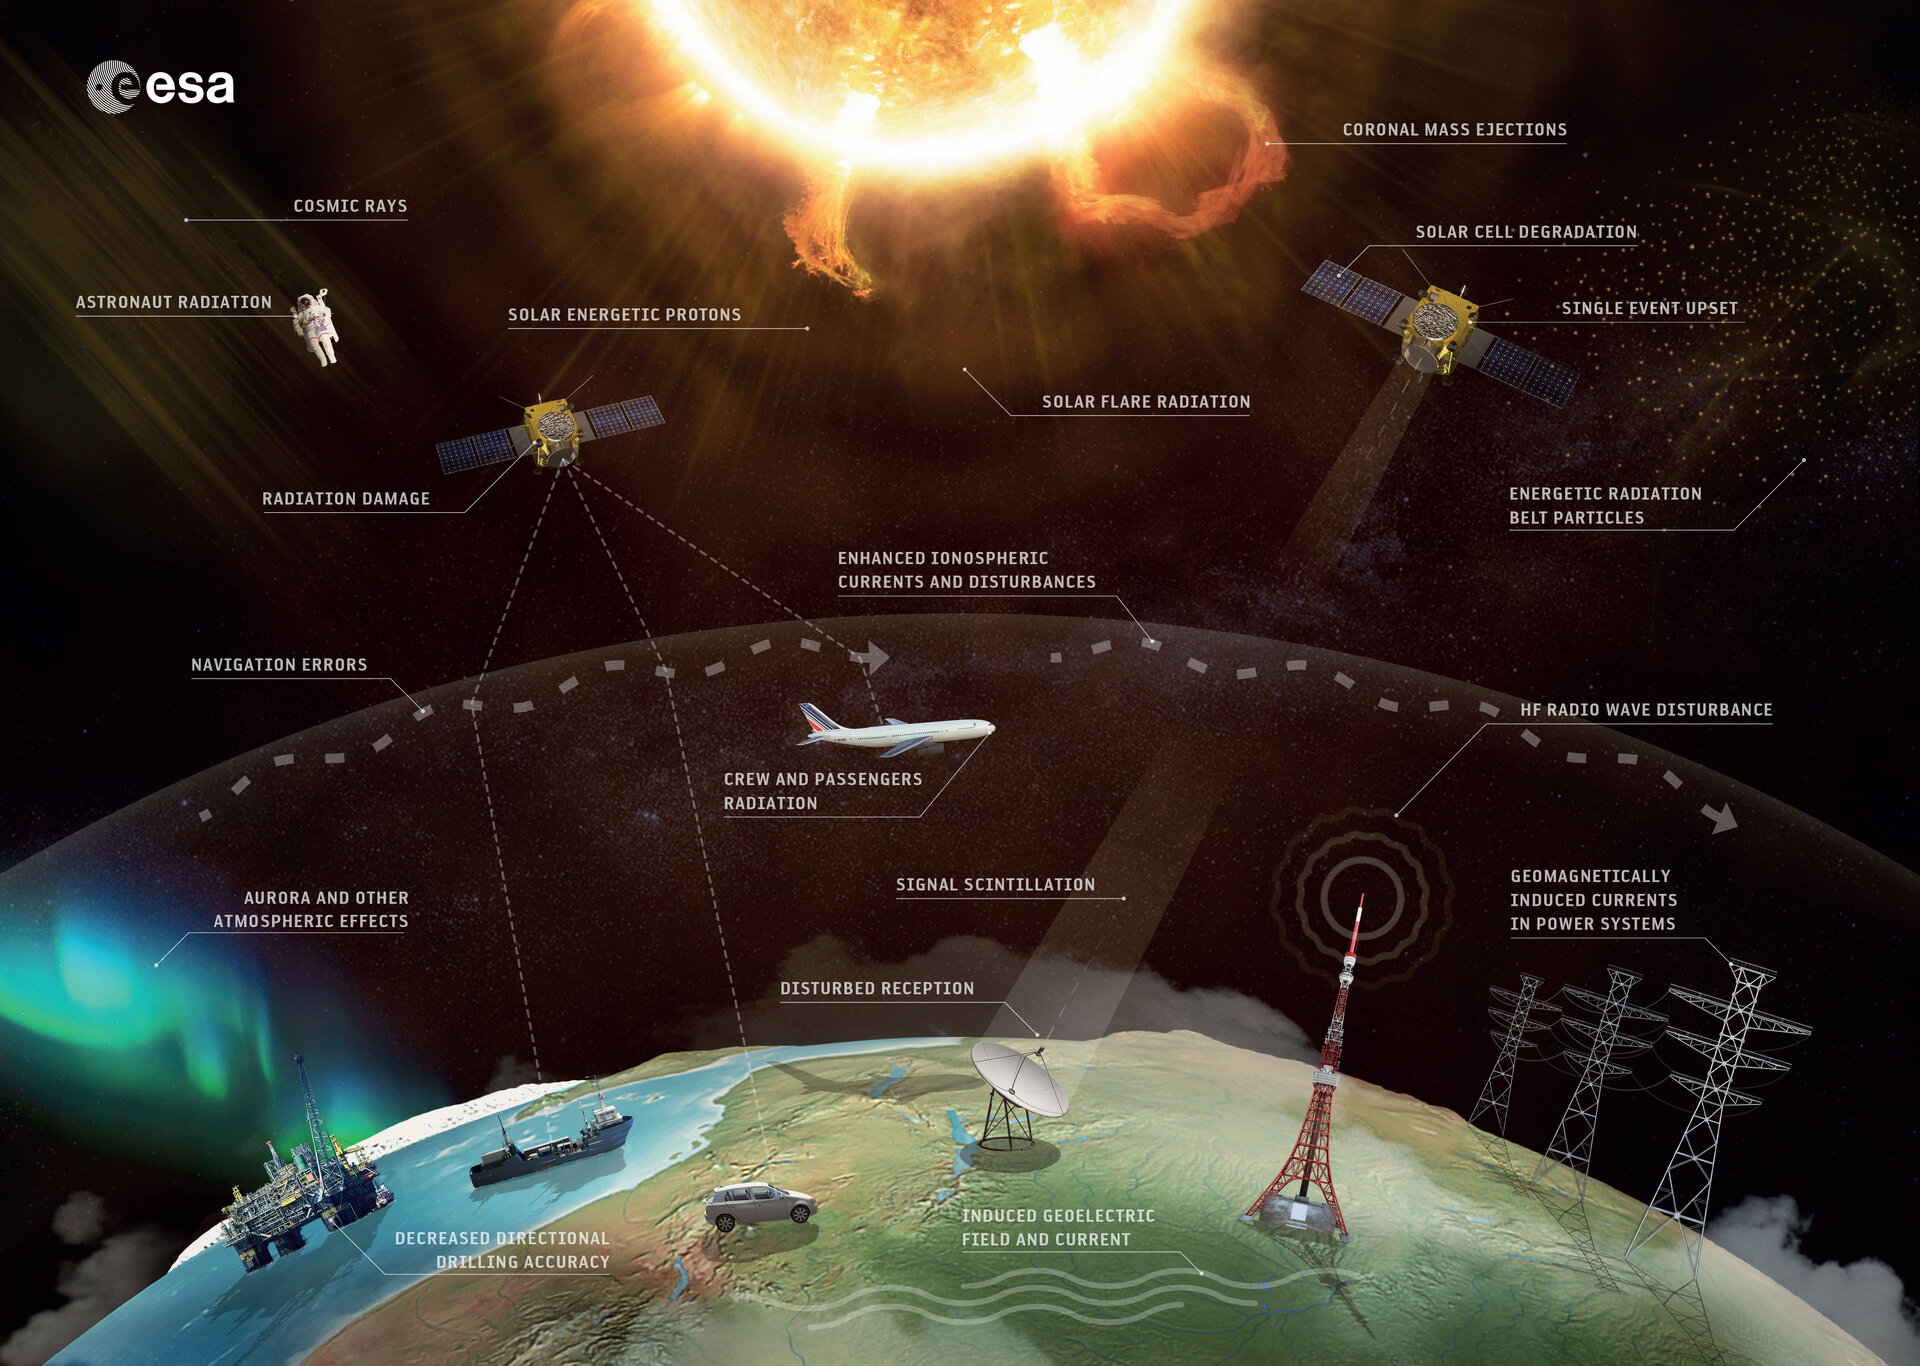

In [1]:
# @title Importing required packages
# only for minute file
import gzip, shutil, struct, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import sys, time, os, subprocess, re, requests
try: # python module for processing netcdf4 file
  import netCDF4 as nc
  print("netCDF4 Module is installed.")
except ImportError:
  print("netCDF4 Module is not installed os installing")
  subprocess.check_call([sys.executable, "-m", "pip", "install", 'netCDF4'])
finally:
  import netCDF4 as nc
import cftime, glob, ftplib
from PIL import Image

netCDF4 Module is not installed os installing


### Functions

In [2]:
# https://gist.github.com/w121211/fbd35d1a8776402ac9fe24654ca8044f
# Defining relative madness function to remove outliner
def relative_madness(x):
    return abs(x[1] - np.median(x)) - np.median(abs(x - np.median(x)))

# Defining spike removing function
def removing_spike(df, n_value):
    """
   Remove spike from signal or time series data based on
   https://gist.github.com/w121211/fbd35d1a8776402ac9fe24654ca8044f

    Parameter:
    ----------
    df = time series data frame to be detected and removed
    n_value = threshold value to remove spike

    Returns
    ------------
    data frame with smooth time series

  """
    df = df.copy()  # Create a copy to avoid modifying the original DataFrame
    cols = df.columns
    for col in cols:
        # Apply relative madness function over a rolling window
        df.loc[:, 'Madness'] = df[col].rolling(window=3, center=True).apply(relative_madness)

        # Replace values where Madness > 3 with NaN
        df.loc[df['Madness'] > n_value, col] = np.nan

    # Interpolate NaN values linearly, with a limit of 5 consecutive NaNs
    df.interpolate(method='linear', limit=5, inplace=True)

    # Drop the Madness column as it's no longer needed
    df.drop(columns=['Madness'], inplace=True)

    return df

In [3]:
#!/usr/bin/env python3
#https://kp.gfz-potsdam.de/en/data
"""
getKpindex.py
===================================
GFZ German Research Centre for Geosciences (CC BY 4.0)
Author I. Wehner
created with Python 3.8.10
last modified on 25 May 2022
to run getKpindex function run:  from getKpindex import getKpindex
-----------------------------------
"""

from datetime import datetime
import json, urllib.request

def __checkdate__(starttime,endtime):
    if starttime > endtime:
        raise NameError("Error! Start time must be before or equal to end time")
    return True

def __checkIndex__(index):
    if index not in ['Kp', 'ap', 'Ap', 'Cp', 'C9', 'Hp30', 'Hp60', 'ap30', 'ap60', 'SN', 'Fobs', 'Fadj']:
        raise IndexError("Error! Wrong index parameter! \nAllowed are only the string parameter: 'Kp', 'ap', 'Ap', 'Cp', 'C9', 'Hp30', 'Hp60', 'ap30', 'ap60', 'SN', 'Fobs', 'Fadj'")
    return True

def __checkstatus__(status):
    if status not in ['all', 'def']:
        raise IndexError("Error! Wrong option parameter! \nAllowed are only the string parameter: 'def'")
    return True

def __addstatus__(url,status):
    if status == 'def':
        url = url + '&status=def'
    return url

def getKpindex(starttime, endtime, index, status='all'):
    """
    ---------------------------------------------------------------------------------
    download 'Kp', 'ap', 'Ap', 'Cp', 'C9', 'Hp30', 'Hp60', 'ap30', 'ap60', 'SN', 'Fobs' or 'Fadj' index data from kp.gfz-potsdam.de
    date format for starttime and endtime is 'yyyy-mm-dd' or 'yyyy-mm-ddTHH:MM:SSZ'
    optional 'def' parameter to get only definitve values (only available for 'Kp', 'ap', 'Ap', 'Cp', 'C9', 'SN')
    Hpo index and Fobs/Fadj does not have the status info
    example: (time, index, status) = getKpindex('2021-09-29', '2021-10-01','Ap','def')
    example: (time, index, status) = getKpindex('2021-09-29T12:00:00Z', '2021-10-01T12:00:00Z','Kp')
    ---------------------------------------------------------------------------------
    """
    result_t=0; result_index=0; result_s=0

    if len(starttime) == 10 and len(endtime) == 10:
        starttime = starttime + 'T00:00:00Z'
        endtime = endtime + 'T23:59:00Z'

    try:
        d1 = datetime.strptime(starttime, '%Y-%m-%dT%H:%M:%SZ')
        d2 = datetime.strptime(endtime, '%Y-%m-%dT%H:%M:%SZ')

        __checkdate__(d1,d2)
        __checkIndex__(index)
        __checkstatus__(status)

        time_string = "start=" + d1.strftime('%Y-%m-%dT%H:%M:%SZ') + "&end=" + d2.strftime('%Y-%m-%dT%H:%M:%SZ')
        url = 'https://kp.gfz-potsdam.de/app/json/?' + time_string  + "&index=" + index
        if index not in ['Hp30', 'Hp60', 'ap30', 'ap60', 'Fobs', 'Fadj']:
            url = __addstatus__(url, status)

        webURL = urllib.request.urlopen(url)
        binary = webURL.read()
        text=binary.decode('utf-8')

        try:
            data = json.loads(text)
            result_t = tuple(data["datetime"])
            result_index = tuple(data[index])
            if index not in ['Hp30', 'Hp60', 'ap30', 'ap60', 'Fobs', 'Fadj']:
                result_s = tuple(data["status"])
        except:
            print(text)

    except NameError as er:
        print(er)
    except IndexError as er:
        print(er)
    except ValueError:
        print("Error! Wrong datetime string")
        print("Both dates must be the same format.")
        print("Datetime strings must be in format yyyy-mm-dd or yyyy-mm-ddTHH:MM:SSZ")
    except urllib.error.URLError:
        print("Connection Error\nCan not reach " + url)
    finally:
        return result_t, result_index, result_s

## Enter first date and number days to be observed



In [4]:
# @title Change first day (date_input) and number consequence days interested (dur_days)
date_input = "2024-05-10" # @param {type:"date"}
dur_days = 4 # @param {type:"integer"}
date_start = datetime.strptime(date_input, '%Y-%m-%d')
# For plot's title
date_d = date_start.strftime('%Y %B %d')
date_l = (date_start+ pd.Timedelta(dur_days-1,'day')).strftime('%Y %B %d')
# day of year of start date
day_of_year = date_start.timetuple().tm_yday
date_end = (date_start+ pd.Timedelta(dur_days,'day')-pd.Timedelta(1,'s'))


##Reading and plotting XRS data

Data link https://www.ngdc.noaa.gov/stp/satellite/goes-r.html

Python example of netcdf and plot commands for use with GOES-R EXIS files
https://cires-stp.github.io/goesr-spwx-examples/examples/exis/xrs_example.html#reading-and-plotting-xrs-data


In [5]:
if date_start > datetime.strptime('2018-01-01', '%Y-%m-%d'):
  url  = 'https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes16/l2/data/xrsf-l2-avg1m_science/'
  file_part1 = "sci_xrsf-l2-avg1m_g16_d"
  file_part2 = "_v2-2-0.nc"
else:
  url  = "https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/science/xrs/goes15/xrsf-l2-avg1m_science/"
  file_part1 = "sci_xrsf-l2-avg1m_g15_d"
  file_part2 = "_v1-0-0.nc"

temp_data1 = []
temp_data2 = []
time_data = []
var_name = ["xrsa_flux", "xrsb_flux"]

flag = 1
for i in range(dur_days):
  date_temp = date_start + pd.Timedelta(i,'day')
  url_path = os.path.join(url, date_temp.strftime('%Y/%m/'))
  file_flux = file_part1 +date_temp.strftime('%Y%m%d')+ file_part2
  # sci_xrsf-l2-avg1m_g16_d20240601_v2-2-0.nc
  # Download `file0` if it does not exist locally
  if not os.path.exists(file_flux):
      with open(file_flux, "wb") as f:
          r = requests.get(url_path + file_flux)
          f.write(r.content)
      print(f"Downloaded {file_flux} successfully.")


  # Open netcdf file for reading data
  ff = nc.Dataset(file_flux)

  # time conversion
  temp_time = cftime.num2pydate(ff.variables["time"][:], ff["time"].units)

  time_data.extend(temp_time)
  temp_data1.extend(ff.variables[var_name [0]][:])
  temp_data2.extend(ff.variables[var_name [1]][:])
  if flag == 1:
    platform = getattr(ff, "platform")
    print("satellite: ", platform)
    print("\nAll variable names")
    print(list(ff.variables.keys()), "\n")
    flag = 0

  ff.close()

# Create a DataFrame with the collected data
xrs_df = pd.DataFrame({
    # 'time': time_data,
    'xrsa_flux': temp_data1,
    'xrsb_flux': temp_data2
})
xrs_df.index = time_data
xrs_df[var_name] = xrs_df[var_name].astype(float)
del temp_time, temp_data1, temp_data2

Downloaded sci_xrsf-l2-avg1m_g16_d20240510_v2-2-0.nc successfully.
satellite:  g16

All variable names
['xrsa_flux', 'xrsa_flux_observed', 'xrsa_flux_electrons', 'xrsb_flux', 'xrsb_flux_observed', 'xrsb_flux_electrons', 'xrsa_flag', 'xrsb_flag', 'xrsa_num', 'xrsb_num', 'time', 'xrsa_flag_excluded', 'xrsb_flag_excluded', 'au_factor', 'corrected_current_xrsb2', 'roll_angle', 'xrsa1_flux', 'xrsa1_flux_observed', 'xrsa1_flux_electrons', 'xrsa2_flux', 'xrsa2_flux_observed', 'xrsa2_flux_electrons', 'xrsb1_flux', 'xrsb1_flux_observed', 'xrsb1_flux_electrons', 'xrsb2_flux', 'xrsb2_flux_observed', 'xrsb2_flux_electrons', 'xrs_primary_chan', 'xrsa1_flag', 'xrsa2_flag', 'xrsb1_flag', 'xrsb2_flag', 'xrsa1_num', 'xrsa2_num', 'xrsb1_num', 'xrsb2_num', 'xrsa1_flag_excluded', 'xrsa2_flag_excluded', 'xrsb1_flag_excluded', 'xrsb2_flag_excluded', 'yaw_flip_flag'] 

Downloaded sci_xrsf-l2-avg1m_g16_d20240511_v2-2-0.nc successfully.
Downloaded sci_xrsf-l2-avg1m_g16_d20240512_v2-2-0.nc successfully.
Downloa

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:138: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


### Reading Solar wind from  GFSF
https://omniweb.gsfc.nasa.gov/


To check the data

http://omniweb.gsfc.nasa.gov/form/sc_merge_min1.html

[About The Interplanetary Magnetic Field (IMF)](https://www.spaceweatherlive.com/en/help/the-interplanetary-magnetic-field-imf.html)

In [6]:
s_i = date_start.timetuple().tm_yday-1 # start date
s_i = s_i*24*60
e_i = date_end.timetuple().tm_yday # end date
e_i = e_i*24*60

# URL of the data file
url = "https://spdf.gsfc.nasa.gov/pub/data/omni/high_res_omni/sc_specific/"
wind_file = f"wind_min_b"+date_start.strftime("%Y")+".txt";
temp_index = pd.date_range(date_start,date_end,freq='min')

url_wind = os.path.join(url,wind_file)

# Fetch the data
query_parameters = {"downloadformat": "txt"}
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36"}

try:
    response = requests.get(url_wind, params=query_parameters)
    response.raise_for_status()  # Raise an exception for HTTP errors
    data = response.text
    lines = data.splitlines()[s_i:e_i]
    # Join the lines into a single string and encode to bytes
    byte_data = "\n".join(lines).encode()
    with open(wind_file, "wb") as f:
      f.write(byte_data)
    print(f"Downloaded {wind_file} successfully.")
except requests.exceptions.RequestException as e:
    print(f"Failed to download {wind_file}: {e}")
    sys.exit(1)  # Exit with a non-zero status code to indicate failure

try:
  wind_df = pd.read_csv(wind_file, delim_whitespace=True, header=None)
  wind_df.index = temp_index
except Exception as e:
    print(f"Error: {e}")

# Drop unnecessary columns
cols_drop = list(range(0, 11)) + list(range(15,22)) + list(range(28, wind_df.shape[1]))
wind_df.drop(wind_df.columns[cols_drop],axis=1,inplace=True)
# Replace any remaining max values with NaN and interpolate again
wind_df.replace(wind_df.max(), np.nan, inplace=True)
wind_df.interpolate(method='linear', axis=1, implace = True)
# Rename the columns
wind_df.columns = ['Bt (nT)', 'Bx (nT)', 'By (nT)', 'Bz (nT)',
                   'Flow speed (km/s)', 'Vx (km/s)','Vy (km/s)',
                   'Vz (km/s)', 'Proton Density','Tempenature (K)']

Downloaded wind_min_b2024.txt successfully.


### Reading Dst data from Kyoto University
https://wdc.kugi.kyoto-u.ac.jp/

In [7]:

s_i = int(date_start.strftime("%d")) # start date
e_i = int(date_end.strftime("%d")) # end date
# URL of the data file
if date_start > datetime.strptime('2023-07-01', '%Y-%m-%d'):
  url = "https://wdc.kugi.kyoto-u.ac.jp/dst_realtime/"+date_start.strftime("%Y%m")+"/dst"+date_start.strftime("%y%m")+".for.request"
elif date_start > datetime.strptime('2017-01-01', '%Y-%m-%d'):
  url  = "https://wdc.kugi.kyoto-u.ac.jp/dst_provisional/"+date_start.strftime("%Y%m")+"/dst"+date_start.strftime("%y%m")+".for.request"
else:
  url  = "https://wdc.kugi.kyoto-u.ac.jp/dst_final/"+date_start.strftime("%Y%m")+"/dst"+date_start.strftime("%y%m")+".for.request"

# Fetch the data
response = requests.get(url)
temp_index = pd.date_range(date_start,date_end,freq='H')
parsed_data = []
if response.status_code == 200:
    data = response.text
    lines = data.splitlines()[s_i-1:e_i]
    for line in lines:
      for j in range(24):
        parsed_data.append(int(line[20 + j * 4:24 + j * 4]))
    dst_df = pd.DataFrame(parsed_data, index =temp_index, columns = ["Dst (nT)"])
else:
  print("Failed to retrieve data. Please check the URL and try again.")
del parsed_data

## Reading Kp index from https://kp.gfz-potsdam.de/en/data

In [8]:

(time, index, status) = getKpindex(date_start.strftime('%Y-%m-%d') , date_end.strftime('%Y-%m-%d')  , 'Kp')
temp_index = pd.date_range(date_start,date_end,freq='3H')
Kp_df = pd.DataFrame(index, index =temp_index, columns = ["Kp index"])

### Plotting all parameter together

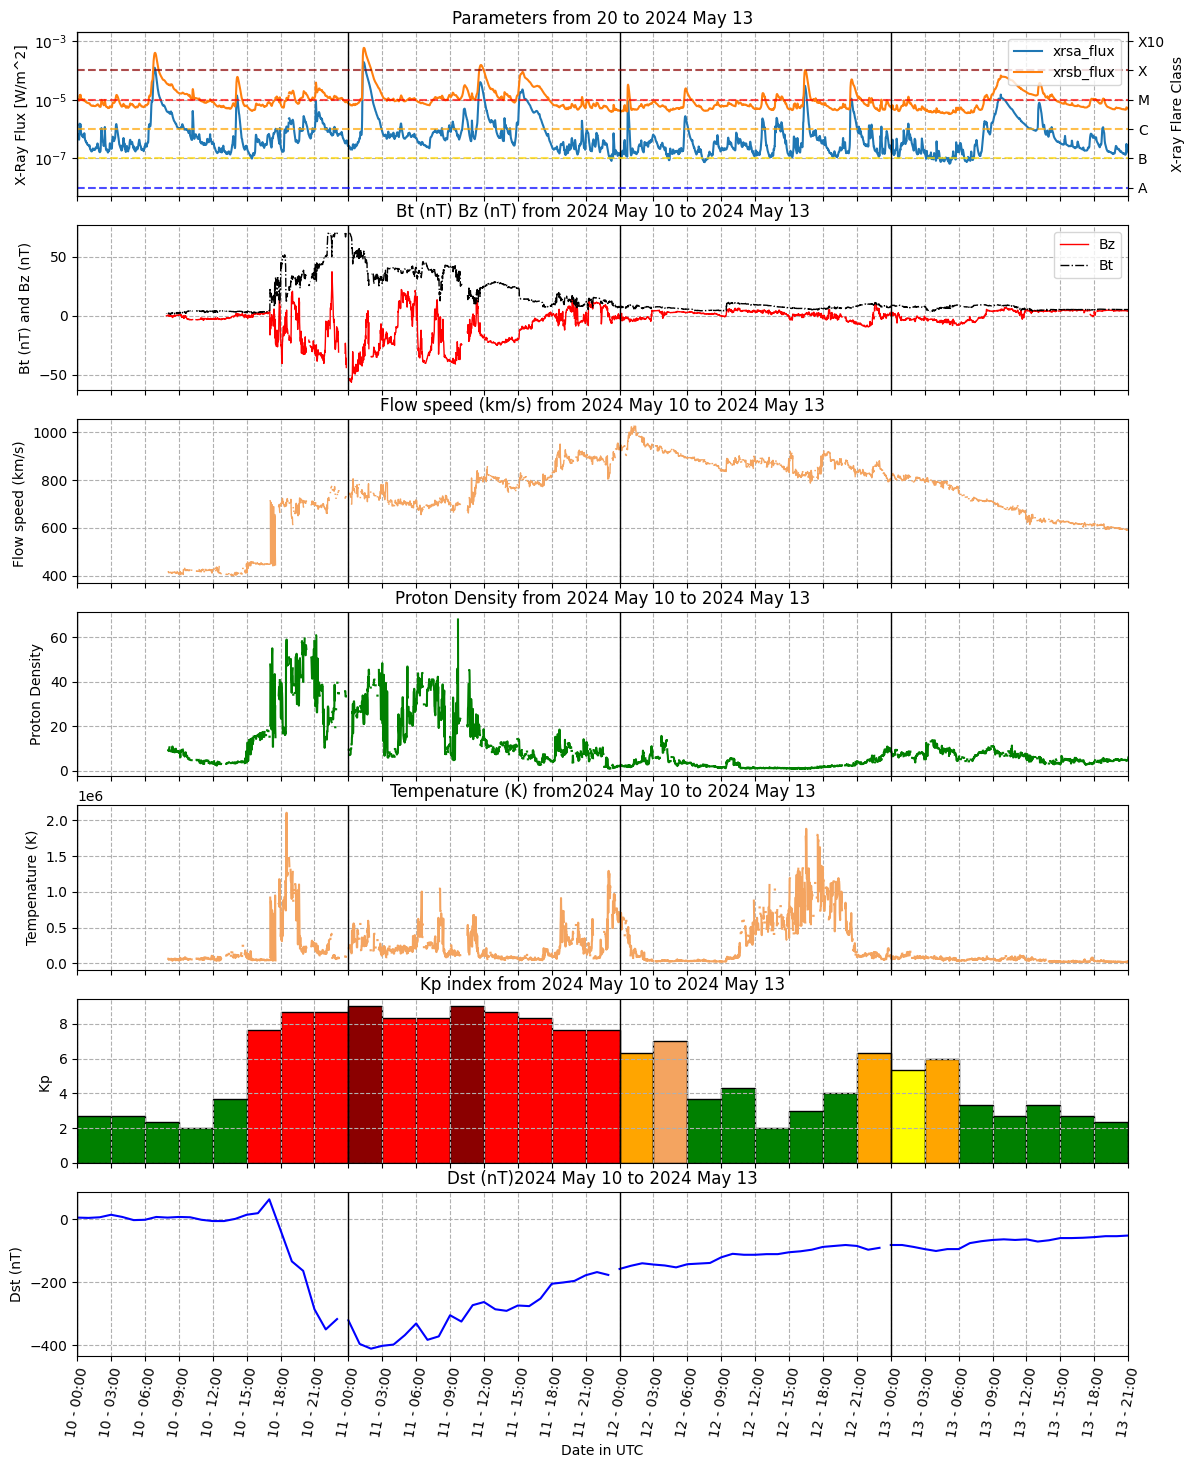

In [14]:
# Group the dst_df (Dst) data by day
dst_df_groups = dst_df.groupby(pd.Grouper(freq = 'D'))
# Group the Kp_df (Kp) data by day
Kp_df_groups = Kp_df.groupby(pd.Grouper(freq = 'D'))
# Group the wind_df (solar wind) data by day
wind_df_groups = wind_df.groupby(pd.Grouper(freq = 'D'))

# Define flux level thresholds and colors
flux_levels = {'A': 1e-8, 'B': 1e-7, 'C': 1e-6, 'M': 1e-5, 'X': 1e-4}
flux_colors = {'A': 'blue', 'B': 'gold', 'C': 'orange', 'M': 'red', 'X': 'darkred'}
# Define colors for each flux level


fig, axs = plt.subplots(7, 1, sharex=True, figsize=(3.0*dur_days, 14.0))

for var in var_name:
  axs[0].plot(xrs_df.index, xrs_df[var], label=var)

for i in range(0,dur_days*1440,1440):
 axs[0].axvline(xrs_df.index[i], color='black', lw=1, alpha=1)

axs[0].set_yscale("log")
# ax1.set_xlabel("UT [day-hour]")
axs[0].set_ylabel("X-Ray Flux [W/m^2]")
axs[0].set_title('Parameters from ' + date_d[:2] + ' to ' + date_l)
axs[0].set_xlim(xrs_df.index.min(), xrs_df.index.max())
axs[0].set_ylim(5e-9,2e-3)
axs[0].grid(True, which="both", ls="--")
axs[0].tick_params(axis='y', which='minor', length=0)
axs[0].legend(var_name,loc="upper right", prop={"size": 10})
axs[0].xaxis.set_major_locator(mticker.MultipleLocator(1/8))

# Add horizontal lines for different flux levels
for level, color in flux_colors.items():
    axs[0].axhline(y=flux_levels[level], color=color, linestyle='--', alpha=0.7)

# Customize y-axis to match the specific plot style
flux_ticks = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
flux_labels = ['A', 'B', 'C', 'M', 'X', 'X10', 'X100']

ax2 = axs[0].twinx()
ax2.set_yscale("log")
ax2.set_yticks(flux_ticks)
ax2.set_yticklabels(flux_labels)
ax2.set_ylim(5e-9,2e-3)
ax2.set_ylabel("X-ray Flare Class")

fig.tight_layout()  # otherwise the right y-label is slightly clipped

for idx, _ in dst_df_groups:
    group0 = Kp_df_groups.get_group(idx)
    group1 = wind_df_groups.get_group(idx)
    group2 = dst_df_groups.get_group(idx)


    # Determine colors based on Kp index values
    col_Kpvalues = group0['Kp index'].values
    clrs_Kp = ['darkred' if x >= 9 else 'red' if x >= 7.5 else 'sandybrown' if x >= 7 else
               'orange' if x >= 6 else 'yellow' if x >= 5 else 'g' for x in col_Kpvalues]
    # Plotting bar chart for Kp index on the first subplot (axs[4])
    axs[5].bar(group0.index, group0['Kp index'], align='edge', width=1/8, edgecolor='k', color=clrs_Kp)
    axs[5].axvline(group0.index[0], color='black', lw=1, alpha=1)

    # Plotting line chart for Bz and Bt (nT) on the second subplot (axs[1])
    axs[1].plot(group1.index, group1['Bz (nT)'],'-',color='red',linewidth=1,label='Bz')
    axs[1].plot(group1.index, group1['Bt (nT)'], '-.',color='black',linewidth=1,label='Bt')
    axs[1].legend(['Bz','Bt'],loc="upper right", prop={"size": 10})
    axs[1].axvline(group1.index[0], color='black', lw=1, alpha=1)

    # Plotting line chart for Flow speed on the second subplot (axs[2])
    axs[2].plot(group1.index, group1['Flow speed (km/s)'],linewidth=1, color='sandybrown')
    axs[2].axvline(group1.index[0], color='black', lw=1, alpha=1)

    axs[3].plot(group1.index, group1['Proton Density'],color='green')
    axs[3].axvline(group1.index[0], color='black', lw=1, alpha=1)

    axs[4].plot(group1.index, group1['Tempenature (K)'], color='sandybrown')
    axs[4].axvline(group1.index[0], color='black', lw=1, alpha=1)

    axs[6].plot(group2.index, group2['Dst (nT)'],color='blue')
    axs[6].axvline(group2.index[0], color='black', lw=1, alpha=1)

# Setting labels, titles, and formatting and
axs[5].set(ylabel='Kp ', title= 'Kp index from ' + date_d + ' to ' + date_l)
axs[5].set_yticks(np.arange(0, 9, 2))
axs[1].set(ylabel='Bt (nT) and Bz (nT)', title= 'Bt (nT) Bz (nT) from ' + date_d + ' to ' + date_l)
axs[2].set( ylabel='Flow speed (km/s) ', title= 'Flow speed (km/s) from ' + date_d + ' to ' + date_l)
axs[3].set(ylabel='Proton Density', title= 'Proton Density from ' + date_d + ' to ' + date_l)
axs[4].set(ylabel='Tempenature (K)', title= 'Tempenature (K) from' + date_d + ' to ' + date_l)
axs[6].set(xlabel='Date in UTC', ylabel='Dst (nT)', title= 'Dst (nT)' + date_d + ' to ' + date_l)
for i in range(len(axs)-1):
  axs[i+1].set_xlim(Kp_df.index.min(), Kp_df.index.max())
  axs[i+1].xaxis.set_major_locator(mticker.MultipleLocator(1/8))
  axs[i+1].grid(ls="--")

axs[6].xaxis.set_major_formatter(mdates.DateFormatter('%d - %H:%M'))
plt.setp(axs[6].get_xticklabels(), rotation=80)
plt.show()


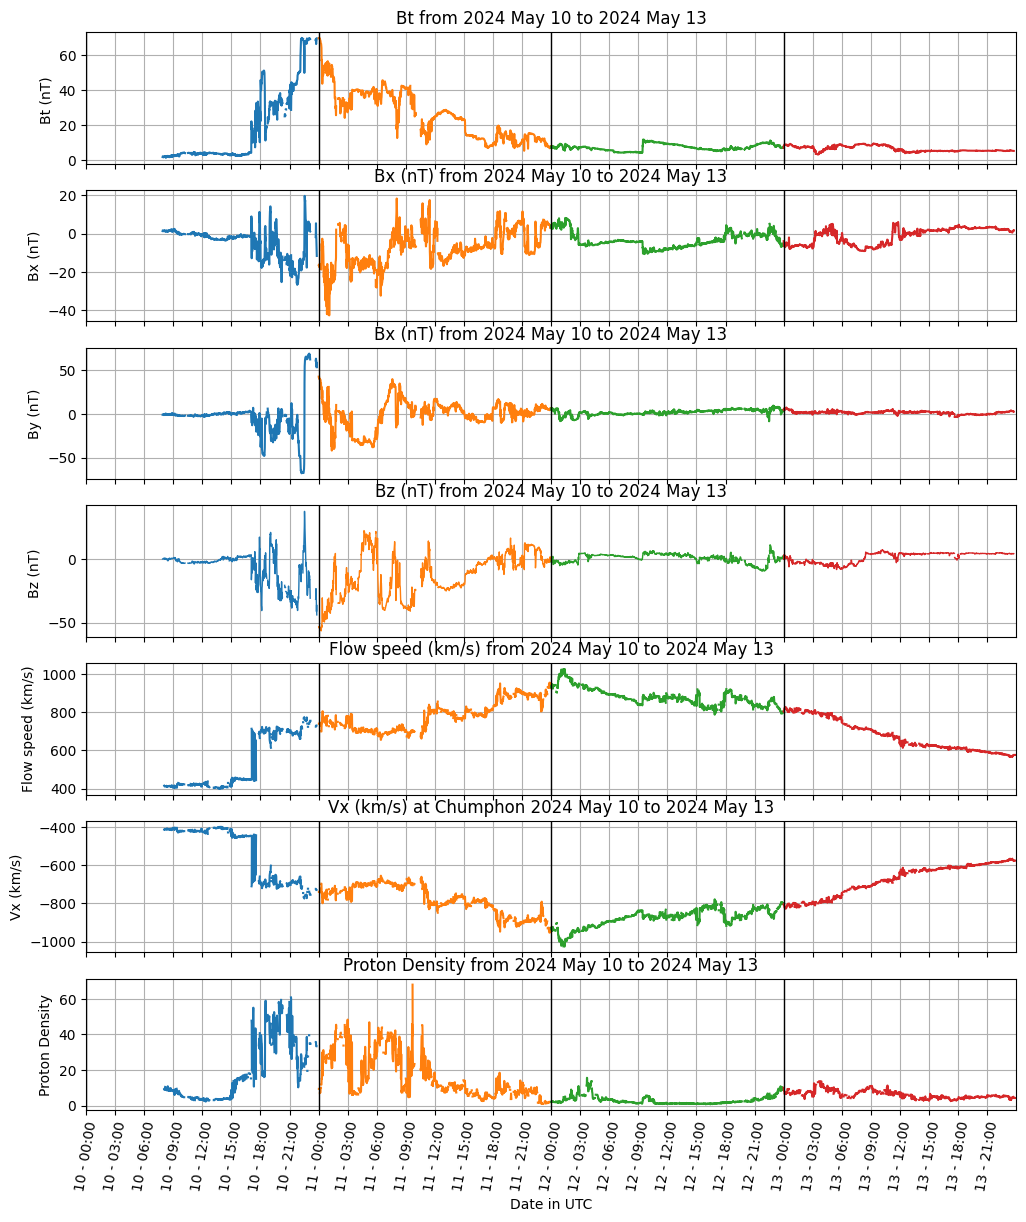

In [10]:
# @title Plotting all solar wind parameters


# Group the wind_df (solar wind) data by day
wind_df_groups = wind_df.groupby(pd.Grouper(freq = 'D'))


fig, axs = plt.subplots(7, 1, sharex=True, figsize=(3.0*dur_days, 14.0))

for idx, _ in wind_df_groups:
    group1 = wind_df_groups.get_group(idx)

# wind_df.columns = ['Bt (nT)', 'Bx (nT)', 'By (nT)', 'Bz (nT)',
#                    'Flow speed (km/s)', 'Vx (km/s)','Vy (km/s)',
#                    'Vz (km/s)', 'Proton Density','Tempenature (K)']

    # Determine colors based on Kp index values
    axs[0].plot(group1.index, group1['Bt (nT)'])
    axs[0].axvline(group1.index[0], color='black', lw=1, alpha=1)

    # Plotting line chart for Dst (nT) on the second subplot (axs[1])
    axs[1].plot(group1.index, group1['Bx (nT)'])
    axs[1].axvline(group1.index[0], color='black', lw=1, alpha=1)

    # Plotting line chart for Dst (nT) on the second subplot (axs[1])
    axs[2].plot(group1.index, group1['By (nT)'])
    axs[2].axvline(group1.index[0], color='black', lw=1, alpha=1)

    # Plotting line chart for H (nT) on the third subplot (axs[2])
    axs[3].plot(group1.index, group1['Bz (nT)'], linewidth=1)
    axs[3].axvline(group1.index[0], color='black', lw=1, alpha=1)

    axs[4].plot(group1.index, group1['Flow speed (km/s)'])
    axs[4].axvline(group1.index[0], color='black', lw=1, alpha=1)
    axs[5].plot(group1.index, group1['Vx (km/s)'])
    axs[5].axvline(group1.index[0], color='black', lw=1, alpha=1)
    axs[6].plot(group1.index, group1['Proton Density'])
    axs[6].axvline(group1.index[0], color='black', lw=1, alpha=1)

# Setting labels, titles, and formatting
axs[0].set(ylabel='Bt (nT) ', title= 'Bt from ' + date_d + ' to ' + date_l)
axs[1].set(ylabel='Bx (nT)', title= 'Bx (nT) from ' + date_d + ' to ' + date_l)
axs[2].set(ylabel='By (nT)', title= 'Bx (nT) from ' + date_d + ' to ' + date_l)
# axs[2].set(xlabel='Date in UTC', ylabel='H (nT) ', title= 'H (nT) at Songkhla from ' + date_d + ' to ' + date_l)
axs[3].set( ylabel='Bz (nT) ', title= 'Bz (nT) from ' + date_d + ' to ' + date_l)
axs[4].set(ylabel='Flow speed (km/s)', title= 'Flow speed (km/s) from ' + date_d + ' to ' + date_l)
axs[5].set(ylabel='Vx (km/s)', title= 'Vx (km/s) at Chumphon ' + date_d + ' to ' + date_l)
axs[6].set(xlabel='Date in UTC', ylabel='Proton Density', title= 'Proton Density from ' + date_d + ' to ' + date_l)
for i in range(len(axs)):
  axs[i].set_xlim(wind_df.index.min(), wind_df.index.max())
  axs[i].xaxis.set_major_locator(mticker.MultipleLocator(1/8))
  axs[i].grid()

axs[6].xaxis.set_major_formatter(mdates.DateFormatter('%d - %H:%M'))
plt.setp(axs[6].get_xticklabels(), rotation=80)
plt.show()

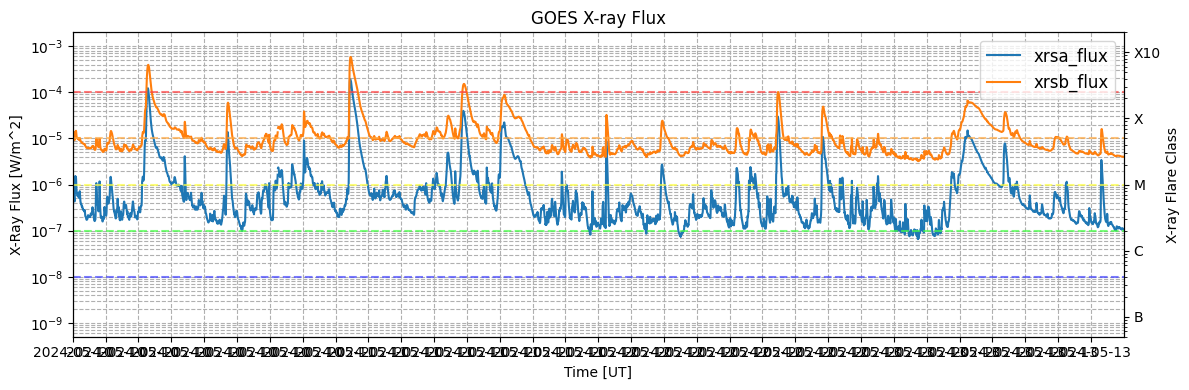

In [15]:
# @title Plotting Solar flare parameters

# Define flux level thresholds and colors
flux_levels = {'A': 1e-8, 'B': 1e-7, 'C': 1e-6, 'M': 1e-5, 'X': 1e-4}
flux_colors = {'A': '#4444FF', 'B': '#44FF44', 'C': '#FFFF44', 'M': '#FFAA44', 'X': '#FF4444'}

# Plot the data
fig, ax1= plt.subplots(figsize=[3.0*dur_days, 4])

for var in var_name:
  ax1.plot(xrs_df.index, xrs_df[var], label=var)

ax1.set_yscale("log")
ax1.set_xlabel("Time [UT]")
ax1.set_ylabel("X-Ray Flux [W/m^2]")
ax1.set_title("GOES X-ray Flux")
ax1.set_xlim(xrs_df.index.min(), xrs_df.index.max())
ax1.set_ylim(5e-10,2e-3)
ax1.grid(True, which="both", ls="--")
ax1.tick_params(axis='y', which='minor', length=0)
ax1.xaxis.set_major_locator(mticker.MultipleLocator(1/8))
ax1.legend(var_name,loc="upper right", prop={"size": 12})
# Add horizontal lines for different flux levels
for level, color in flux_colors.items():
    ax1.axhline(y=flux_levels[level], color=color, linestyle='--', alpha=0.7)

# Customize y-axis to match the specific plot style
flux_ticks = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
flux_labels = ['A', 'B', 'C', 'M', 'X', 'X10', 'X100']

ax2 = ax1.twinx()
ax2.set_yscale("log")
ax2.set_yticks(flux_ticks)
ax2.set_yticklabels(flux_labels)
ax2.set_ylim(5e-8,2e-3)
ax2.set_ylabel("X-ray Flare Class")

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

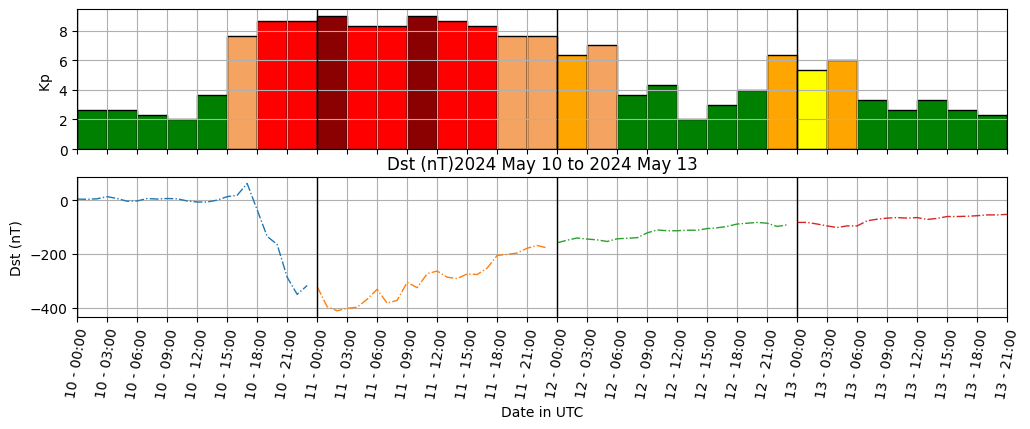

In [12]:
# @title Plotting Kp and Dst indices

# Group the dst_df (Dst) data by day
dst_df_groups = dst_df.groupby(pd.Grouper(freq = 'D'))
# Group the Kp_df (Kp) data by day
Kp_df_groups = Kp_df.groupby(pd.Grouper(freq = 'D'))


fig, axs = plt.subplots(2, 1, sharex=True, figsize=(3.0*dur_days, 4.0))

for idx, _ in Kp_df_groups:
    group0 = Kp_df_groups.get_group(idx)
    group1 = dst_df_groups.get_group(idx)
       # Determine colors based on Kp index values
    col_Kpvalues = group0['Kp index'].values
    clrs_Kp = ['darkred' if x >= 9 else 'red' if x >= 8 else 'sandybrown' if x >= 7 else
               'orange' if x >= 6 else 'yellow' if x >= 5 else 'g' for x in col_Kpvalues]
    # Plotting bar chart for Kp index on the first subplot (axs[0])
    axs[0].bar(group0.index, group0['Kp index'], align='edge', width=1/8, edgecolor='k', color=clrs_Kp)
    axs[0].axvline(group0.index[0], color='black', lw=1, alpha=1)

    axs[1].plot(group1.index, group1['Dst (nT)'], '-.', linewidth=1,label='Dst')
    axs[1].axvline(group1.index[0], color='black', lw=1, alpha=1)

axs[0].set(ylabel='Kp ')
axs[0].set_yticks(np.arange(0, 9, 2))
axs[1].set(xlabel='Date in UTC', ylabel='Dst (nT)', title= 'Dst (nT)' + date_d + ' to ' + date_l)

for i in range(len(axs)):
  axs[i].set_xlim(Kp_df.index.min(), Kp_df.index.max())
  axs[i].xaxis.set_major_locator(mticker.MultipleLocator(1/8))
  axs[i].grid()

axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%d - %H:%M'))
plt.setp(axs[1].get_xticklabels(), rotation=80)
plt.show()